# Uploading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from mne import io
from mne import read_epochs

#### File nomenclature
import _epo.fif files
    
    format: "g"+ group_number + player_type + subject +'_epo.fif'
    player_type: ["solo", "dual"]
    subject: [1, 2]

In [2]:
url = './data/'

print("\n========= epoch_1 ==========")

# epoch_1
file_name_1 = 'g1dual1_epo.fif' # eg. 'g1dual1_epo.fif'
epoch_1 = read_epochs(url + file_name_1)
print("\n========= epoch_2 ==========")

# epoch_2
file_name_2 = 'g1solo1_epo.fif' # eg. 'g1dual2_epo.fif'
epoch_2 = read_epochs(url + file_name_2)


========= epoch_1 ==========
Reading ./data/g1dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated

========= epoch_2 ==========
Reading ./data/g1solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


In [3]:
X_train = epoch_1.get_data()
y_train = np.array(epoch_1.events[:, -1], dtype = 'float32')

print(X_train.shape)
print(y_train.shape)

(636, 32, 410)
(636,)


In [4]:
X_val = epoch_2.get_data()
y_val = np.array(epoch_2.events[:, -1], dtype = 'float32')

print(X_val.shape)
print(y_val.shape)

(240, 32, 410)
(240,)


In [5]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
print(X_train.shape)
print(X_val.shape)

(636, 1, 32, 410)
(240, 1, 32, 410)


## Separating Regions
Region channels
- 0-7 --> F
- 7-11, 12-15 --> C
- 16-25 --> P
- 25 -- 32> 0
- 11-12, 15-16 --> T

In [6]:
X_train_F = X_train[:, : ,0:7, :]
X_train_P = X_train[:, : , 16:25, :]
X_train_O = X_train[:, : , 25:32, :]
X_train_C1 = X_train[:, : , 7:11, :]
X_train_C2 = X_train[:, : , 12:15, :]
X_train_C = np.concatenate((X_train_C1, X_train_C2), axis=2)
X_train_T1 = X_train[:, : , 11:12, :]
X_train_T2 = X_train[:, : , 15:16, :]
X_train_T = np.concatenate((X_train_T1, X_train_T2), axis=2)
print("F",X_train_F.shape)
print("C", X_train_C.shape)
print("P", X_train_P.shape)
print("O", X_train_O.shape)
print("T", X_train_T.shape)


F (636, 1, 7, 410)
C (636, 1, 7, 410)
P (636, 1, 9, 410)
O (636, 1, 7, 410)
T (636, 1, 2, 410)


In [7]:
X_val_F = X_val[:,  : ,0:7, :]
X_val_P = X_val[:, : , 16:25, :]
X_val_O = X_val[:, : , 25:32, :]
X_val_C1 = X_val[:, : , 7:11, :]
X_val_C2 = X_val[:, : , 12:15, :]
X_val_C = np.concatenate((X_val_C1, X_val_C2), axis=2)
X_val_T1 = X_val[:, : , 11:12, :]
X_val_T2 = X_val[:, : , 15:16, :]
X_val_T = np.concatenate((X_val_T1, X_val_T2), axis=2)

print("F", X_val_F.shape)
print("C", X_val_C.shape)
print("P", X_val_P.shape)
print("O", X_val_O.shape)
print("T", X_val_T.shape)

F (240, 1, 7, 410)
C (240, 1, 7, 410)
P (240, 1, 9, 410)
O (240, 1, 7, 410)
T (240, 1, 2, 410)


#### Creating Tensors

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
X_F = torch.Tensor(X_train_F)
X_C = torch.Tensor(X_train_C)
X_P = torch.Tensor(X_train_P)
X_O = torch.Tensor(X_train_O)
X_T = torch.Tensor(X_train_T)
y = torch.Tensor(y_train)
y = y - 1
y = y.unsqueeze(1)
print("X shape")
print("F :",X_F.size())
print("C :",X_C.size())
print("P :",X_P.size())
print("O :",X_O.size())
print("T :",X_T.size())
print("y shape:",y.size())

print('\n')

X_val_F = torch.Tensor(X_val_F)
X_val_C = torch.Tensor(X_val_C)
X_val_P = torch.Tensor(X_val_P)
X_val_O = torch.Tensor(X_val_O)
X_val_T = torch.Tensor(X_val_T)
y_val = torch.Tensor(y_val)
y_val = y_val - 1
y_val = y_val.unsqueeze(1)
print("X_val shape")
print("F :",X_val_F.size())
print("C :",X_val_C.size())
print("P :",X_val_P.size())
print("O :",X_val_O.size())
print("T :",X_val_T.size())
print("y_val shape:",y_val.size())

X shape
F : torch.Size([636, 1, 7, 410])
C : torch.Size([636, 1, 7, 410])
P : torch.Size([636, 1, 9, 410])
O : torch.Size([636, 1, 7, 410])
T : torch.Size([636, 1, 2, 410])
y shape: torch.Size([636, 1])


X_val shape
F : torch.Size([240, 1, 7, 410])
C : torch.Size([240, 1, 7, 410])
P : torch.Size([240, 1, 9, 410])
O : torch.Size([240, 1, 7, 410])
T : torch.Size([240, 1, 2, 410])
y_val shape: torch.Size([240, 1])


In [11]:
train_ds_F = TensorDataset(X_F, y)
valid_ds_F = TensorDataset(X_val_F, y_val)

train_ds_C = TensorDataset(X_C, y)
valid_ds_C = TensorDataset(X_val_C, y_val)

train_ds_P = TensorDataset(X_P, y)
valid_ds_P = TensorDataset(X_val_P, y_val)

train_ds_O = TensorDataset(X_O, y)
valid_ds_O = TensorDataset(X_val_O, y_val)

train_ds_T = TensorDataset(X_T, y)
valid_ds_T = TensorDataset(X_val_T, y_val)

# train_size = int(X.size()[0] * 0.8)
# valid_size = X.size()[0] - train_size

# train_set, valid_set = torch.utils.data.random_split(train_ds, [train_size, valid_size])

BATCH_SIZE= 64

train_iterator_F = torch.utils.data.DataLoader(dataset=train_ds_F, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_F = torch.utils.data.DataLoader(dataset=valid_ds_F, batch_size=BATCH_SIZE, shuffle=False)

train_iterator_C = torch.utils.data.DataLoader(dataset=train_ds_C, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_C = torch.utils.data.DataLoader(dataset=valid_ds_C, batch_size=BATCH_SIZE, shuffle=False)

train_iterator_P = torch.utils.data.DataLoader(dataset=train_ds_P, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_P = torch.utils.data.DataLoader(dataset=valid_ds_P, batch_size=BATCH_SIZE, shuffle=False)

train_iterator_O = torch.utils.data.DataLoader(dataset=train_ds_O, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_O = torch.utils.data.DataLoader(dataset=valid_ds_O, batch_size=BATCH_SIZE, shuffle=False)

train_iterator_T = torch.utils.data.DataLoader(dataset=train_ds_T, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_T = torch.utils.data.DataLoader(dataset=valid_ds_T, batch_size=BATCH_SIZE, shuffle=False)

#### Model

In [12]:
class CNN(nn.Module):
    def __init__(self, input_x, input_dim, hidden_dims, output_dim, dropout):
        super(CNN, self).__init__()
        self.seq_len = input_x[-1]
        self.hidden_dims = hidden_dims
        
        # layer 1 (BatchNorm)
        self.layer1 = nn.BatchNorm2d(input_dim)     
        
        # layer 2 (Conv2d, tanh)
        self.layer2 = nn.Sequential(nn.Conv2d(input_dim, self.hidden_dims[1], kernel_size = (input_dim, self.hidden_dims[0]), 
                                        stride = 1), nn.Tanh())     
        
        # layer 3 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer3_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2],kernel_size = (1, 5), 
                                        stride = (1, 5)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 10), 
                                        stride = (1, 10)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 15), 
                                        stride = (1, 15)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 4  (concat, dropout, tanh)
        
        # layer 5 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer5_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 2), 
                                        stride = (1, 2)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 4), 
                                        stride = (1, 4)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 11), 
                                        stride = (1, 11)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 6 (concat, dropout, tanh)
        
        # layer 7 (Maxpool, tanh, dropout)
        self.layer7 = nn.Sequential(nn.MaxPool2d(kernel_size = (1, 2), stride = (1, 2)), nn.Tanh(), nn.Dropout2d(dropout))  
        
        # layer 8 (Flatten, tanh, dropout)
        self.layer8 = nn.Sequential(nn.Flatten(), nn.Linear(13888, 128), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 9 (Linear, Sigmoid)
        self.layer9 = nn.Sequential(nn.Linear(128, output_dim), nn.Sigmoid())
        
        self.dropout = nn.Sequential(nn.Dropout2d(dropout), nn.Tanh())
    
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out_3_1 = self.layer3_1(out)
        out_3_2 = self.layer3_2(out)
        out_3_3 = self.layer3_3(out)
        out = torch.cat((out_3_1, out_3_2, out_3_3),dim = 3)  #layer 4
        out = self.dropout(out)
        out_5_1 = self.layer5_1(out)
        out_5_2 = self.layer5_2(out)
        out_5_3 = self.layer5_3(out)
        out = torch.cat((out_5_1, out_5_2, out_5_3),dim = 3)  #layer 6
        out = self.dropout(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        
        return out

In [13]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [14]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
       # print("predictions",predictions)
        #print("labels", labels)
        predicted = predictions.round()
#         print("train predicted",predicted)
#         _, predicted = torch.max(predictions.data, 1) 
        #returns max value, indices
#         predicted = predicted.unsqueeze(1)
        total += labels.size(0)  #keep track of total
#         correct += (predicted == labels).sum().item()  #.item() give the raw number
        correct += (predicted == labels).sum().item()
#         print("label",labels.size())
#         print("predicted", predicted.size())
#         print("correct", correct)
#         print("total", total)
#         print("acc", correct/ total)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicted

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

#             _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicted = predictions.round()
#             print("test predicted",predicted)
#             predicted = predicted.unsqueeze(1)
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , predicted

In [15]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Region P

In [16]:
class CNN(nn.Module):
    def __init__(self, input_x, input_dim, hidden_dims, output_dim, dropout):
        super(CNN, self).__init__()
        self.seq_len = input_x[-1]
        self.hidden_dims = hidden_dims
        
        # layer 1 (BatchNorm)
        self.layer1 = nn.BatchNorm2d(input_dim)     
        
        # layer 2 (Conv2d, tanh)
        self.layer2 = nn.Sequential(nn.Conv2d(input_dim, self.hidden_dims[1], kernel_size = (input_dim, self.hidden_dims[0]), 
                                        stride = 1), nn.Tanh())     
        
        # layer 3 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer3_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2],kernel_size = (1, 5), 
                                        stride = (1, 5)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 10), 
                                        stride = (1, 10)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 15), 
                                        stride = (1, 15)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 4  (concat, dropout, tanh)
        
        # layer 5 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer5_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 2), 
                                        stride = (1, 2)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 4), 
                                        stride = (1, 4)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 11), 
                                        stride = (1, 11)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 6 (concat, dropout, tanh)
        
        # layer 7 (Maxpool, tanh, dropout)
        self.layer7 = nn.Sequential(nn.MaxPool2d(kernel_size = (1, 2), stride = (1, 2)), nn.Tanh(), nn.Dropout2d(dropout))  
        
        # layer 8 (Flatten, tanh, dropout)
        self.layer8 = nn.Sequential(nn.Flatten(), nn.Linear(17856, 128), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 9 (Linear, Sigmoid)
        self.layer9 = nn.Sequential(nn.Linear(128, output_dim), nn.Sigmoid())
        
        self.dropout = nn.Sequential(nn.Dropout2d(dropout), nn.Tanh())
    
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out_3_1 = self.layer3_1(out)
        out_3_2 = self.layer3_2(out)
        out_3_3 = self.layer3_3(out)
        out = torch.cat((out_3_1, out_3_2, out_3_3),dim = 3)  #layer 4
        out = self.dropout(out)
        out_5_1 = self.layer5_1(out)
        out_5_2 = self.layer5_2(out)
        out_5_3 = self.layer5_3(out)
        out = torch.cat((out_5_1, out_5_2, out_5_3),dim = 3)  #layer 6
        out = self.dropout(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        
        return out

In [17]:
input_x = X_P.size()
input_dim = 1
output_dim = 1
hidden_dims = [1, 128, 64, 32]
learning_rate = 0.0001
num_epochs = 50
dropout = 0.35

model_P = CNN(input_x, input_dim, hidden_dims, output_dim, dropout).to(device)
model_P.apply(initialize_weights)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_P.parameters(), lr=learning_rate)

In [18]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")
    
#     start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(model_P, train_iterator_P, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(model_P, valid_iterator_P, criterion)

    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

#         print(predicted_train)
#         print(predicted_eval)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.579 | Train Acc: 81.60%
	 Val. Loss: 0.680 |  Val. Acc: 83.46%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.479 | Train Acc: 80.66%
	 Val. Loss: 0.584 |  Val. Acc: 83.46%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.445 | Train Acc: 83.02%
	 Val. Loss: 0.499 |  Val. Acc: 83.46%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.395 | Train Acc: 83.02%
	 Val. Loss: 1.057 |  Val. Acc: 16.54%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.360 | Train Acc: 84.75%
	 Val. Loss: 0.522 |  Val. Acc: 88.98%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.332 | Train Acc: 86.64%
	 Val. Loss: 0.356 |  Val. Acc: 83.46%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.323 | Train Acc: 86.32%
	 Val. Loss: 0.429 |  Val. Acc: 82.02%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.309 | Train Acc: 87.42%
	 Val. Loss: 0.298 |  Val. Acc: 87.93%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.281 | Train Acc: 88.84%
	 Val. Loss: 0.296 |  Val. Acc: 86.55%
Epoch: 10 | Epoch Time: 0m 0

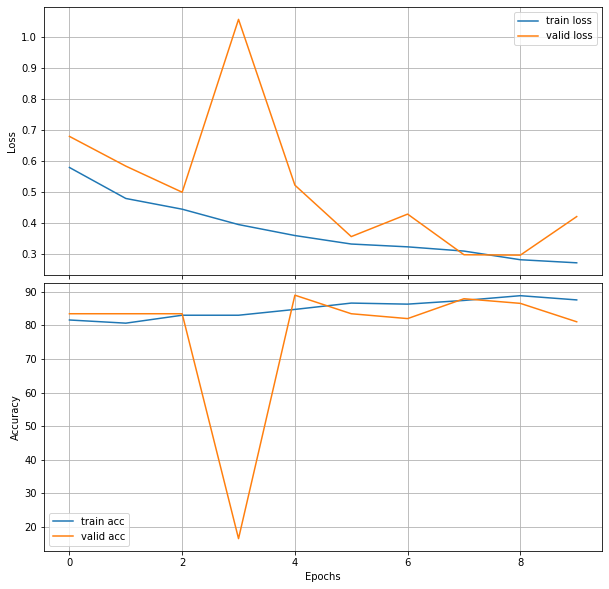

In [19]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()

In [20]:
subject_no = 1
val_acc_list = []
subject_no_list = []

for i in range(1, 20):
    for j in range(1,3):
        print("Subject No:", subject_no)
        subject_no_list.append(subject_no)
        subject_no += 1
        
        print(f"g{i}dual{j}_epo.fif")
        print(f"g{i}solo{j}_epo.fif")
        test_file_1 = 'g'+str(i)+'dual'+str(j)+'_epo.fif' # eg. 'g1dual1_epo.fif'
        epoch_1 = read_epochs(url + test_file_1)
        test_file_2 = 'g'+str(i)+'solo'+str(j)+'_epo.fif' # eg. 'g1dual1_epo.fif'
        epoch_2 = read_epochs(url + test_file_2)

        X_test1 = epoch_1.get_data()
        y_test1 = np.array(epoch_1.events[:, -1], dtype = 'float32')

        X_test2 = epoch_2.get_data()
        y_test2 = np.array(epoch_2.events[:, -1], dtype = 'float32')
        
        
        X_test = np.concatenate((X_test1, X_test2), axis=0)
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
        
        X_test = X_test[:, : , 16:25, :]          #P
        
        y_test = np.concatenate((y_test1, y_test2), axis=0)
        # print(X_train.shape)
        # print(y_train.shape)

        X_test = torch.Tensor(X_test)
        y_test = torch.Tensor(y_test)
        y_test = y_test-1
        y_test = y_test.unsqueeze(1)
        # print(X_val.size())
        # print(y_val.size())

        test_ds = TensorDataset(X_test, y_test)

        BATCH_SIZE= 64

        test_iterator = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False)

        test_losses = []
        test_accs = []
        test_predicted_labels = []
        best_test_loss = float("inf")

        # for epoch in range(N_EPOCHS):
        start_time = time.time()

        test_loss, test_acc, predicted_test_eval = evaluate(model_P, test_iterator, criterion)

        test_losses.append(test_loss); test_accs.append(test_acc); test_predicted_labels.append(predicted_test_eval)
        
        val_acc_list.append(test_acc)
        end_time = time.time()
    
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # if (epoch+1) % 5 == 0:
        # print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc:.2f}%')
        print("================================================")
        print("================================================")
        print("================================================")

        #         print(predicted_train)
        #         print(predicted_eval)

        # if test_loss < best_test_loss:
        #     best_test_loss = test_loss
        #         print("Model:{} saved.".format(type(model).__name__))
        #         torch.save(model.state_dict(), 'models/checkpoint.pth.tar')
        #         4best_model_index = i

Subject No: 1
g1dual1_epo.fif
g1solo1_epo.fif
Reading ./data/g1dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g1solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.389 |  Test. Acc: 85.80%
Subject No: 2
g1dual2_epo.fif
g1solo2_epo.fif
Reading ./data/g1dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g1solo

Not setting metadata
744 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g6solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.480 |  Test. Acc: 76.84%
Subject No: 12
g6dual2_epo.fif
g6solo2_epo.fif
Reading ./data/g6dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
744 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g6solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correct

        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.537 |  Test. Acc: 70.93%
Subject No: 22
g11dual2_epo.fif
g11solo2_epo.fif
Reading ./data/g11dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
516 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g11solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.627 |  Test. Acc: 68.77%
Subject No: 23
g12dual1_epo.fif
g12solo1_epo.fif
Reading ./data/g12dual1_epo.fif ...
    Found the data of interest:
        t = 

	 Test. Loss: 0.539 |  Test. Acc: 77.22%
Subject No: 32
g16dual2_epo.fif
g16solo2_epo.fif
Reading ./data/g16dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g16solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.590 |  Test. Acc: 72.43%
Subject No: 33
g17dual1_epo.fif
g17solo1_epo.fif
Reading ./data/g17dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied


In [21]:
import xlsxwriter

workbook = xlsxwriter.Workbook('CNN P Channel Test with another subj.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write(0, 0, 'Subject No')
worksheet.write(0, 1, 'Val Accuracy')

for i in range(len(subject_no_list)):
    worksheet.write(i+1, 0, subject_no_list[i])
    worksheet.write(i+1, 1, val_acc_list[i])
    
workbook.close()